# Introduction

The core idea of this package is to perform least-squares fits of quasinormal modes to ringdown waveforms. The user initialises the waveform they want to perform fits on as a class. Then, there are various methods associated with the class to perform the fits.

Currently, there are three types of waveform class which the user can initialise:

 - **Simulation**: Perform fits to a waveform from the SXS catalog. This makes use of the `sxs` Python package to automatically download the simulation, so that you only need to specify the ID. 

 - **Surrogate**: Perform fits to a waveform generated by a surrogate. Currently implemented are NRSur7dq4 and NRHybSur3dq8.

 - **Custom**: Provide a dictionary of modes to perform fits to. 

All of these classes inherit functions from `Waveform/Base.BaseClass`.

# Analysing a SXS waveform

To demonstrate the features of the code we will work with the simulation SXS:BBH:0305, but everything will apply to surrogate or custom waveforms (the main differences are in the class initialization).

## Class initialization

The only required argument for an SXS waveform is a simulation ID. However, it is a good idea to also change the zero-time to something more useful. Here we use the peak of the absolute value of the (2,2) mode (see the `Simulation` docstring for other options, including the ability to **transform** the modes with a rotation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qnmfits

sim = qnmfits.Simulation(ID=305, zero_time=(2,2))

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [2]:
sim.print_metadata()

----------  -------------------------------------------------
chi1        [ 3.41456411e-08 -4.09141073e-08  3.29976580e-01]
chi2        [ 3.75379590e-08  3.17672732e-08 -4.39948325e-01]
Mf          0.952032939704
chif        [ 5.25395868e-08 -2.45673366e-08  6.92085187e-01]
vf          [-2.97055913e-04 -3.34747686e-04 -2.23049872e-08]
mass ratio  1.2212026034520165
chi_eff     -0.016648668848197472
chip        5.217419053959003e-08
----------  -------------------------------------------------


Upon initialization various quantities get automatically calculated. This includes
 - Time derivatives of each mode (`sim.hdot`)
 - The evolving mass of the remnant black hole (`sim.Moft`), computed by integrating the energy flux backwards from the final remnant value
 - The evolving spin of the remnant black hole (`sim.chioft`), computed by integrating the angular momentum flux backwards from the final spin vector
 - The frequency evolution of each mode (`sim.foft`)
 
For SXS waveforms, we also get various derived metadata quantities such as the precession spin parameter, `sim.chip`, and the effective spin parameter `sim.chi_eff`.

## Perform a single QNM fit

Perform fits with the `sim.ringdown_fit` method:

In [3]:
sim.ringdown_fit?

Signature:
sim.ringdown_fit(
    t0=0,
    T=100,
    Mf=None,
    chif=None,
    modes=[(2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (2, 2, 6), (2, 2, 7)],
    mirror_modes=[],
    hlm_modes=[(2, 2)],
    t0_method='geq',
)
Docstring:
Perform a least squares fit to the simulation data using a ringdown 
model.

Parameters
----------
t0 : float, optional
    The start time of the ringdown model, relative to the chosen zero
    time. The default is 0.
    
T : float, optional
    The end time of the analysis, relative to t0. The default is 100.
    
Mf : float, optional
    The remnant black hole mass, which along with chif determines the 
    QNM frequencies. If None, the true remnant mass is used. The 
    default is None.
    
chif : float, optional
    The magnitude of the remnant black hole spin. If None, the true
    remnant spin is used. The default is None.
    
modes : list, optional
    A list of (l,m,n) tuples (where l is the angular number of the 
    mod

Mismatch = 1.2801455067101841e-06


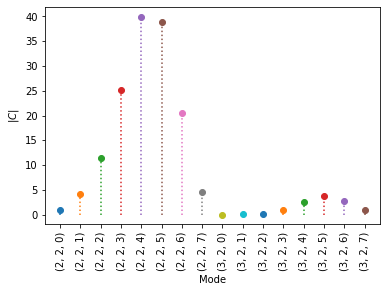

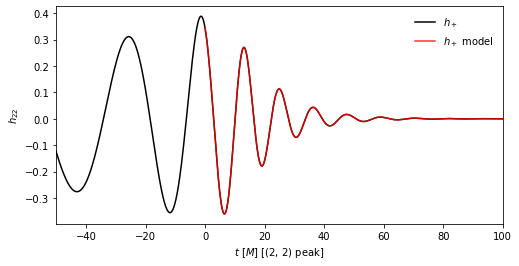

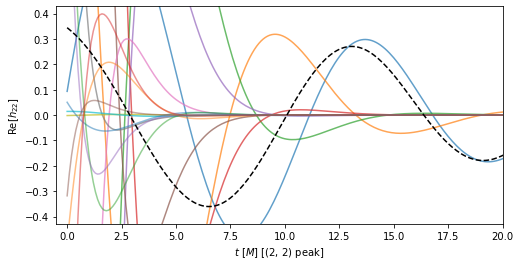

In [4]:
# Perform a fit to the (2,2) and (3,2) spherical modes using a ringdown model 
# with the (2,2,n) and (3,2,n) QNMs, up to and including n = 7:

hlm_modes = [(2,2), (3,2)]
modes = [(l,2,n) for l in range(2,3+1) for n in range(7+1)]

best_fit = sim.ringdown_fit(
    t0=0, 
    T=100, 
    modes=modes, 
    hlm_modes=hlm_modes
)

print(f"Mismatch = {best_fit['mismatch']}")

# Plot the result

sim.plot_mode_amplitudes(
    best_fit['weighted_C'][2,2], best_fit['mode_labels'], log=False)

sim.plot_ringdown(
    hlm_mode=(2,2), best_fit=best_fit)

peak_value = max(abs(sim.h[2,2]))

sim.plot_ringdown_modes(
    best_fit,
    hlm_mode=(2,2),
    xlim=(-0.5,20), 
    ylim=(-peak_value*1.1,peak_value*1.1), 
    legend=False)

## Perform fits for a range of ringdown start times

There is a `sim.mismatch_t0_array` method for fitting for a range of start times.

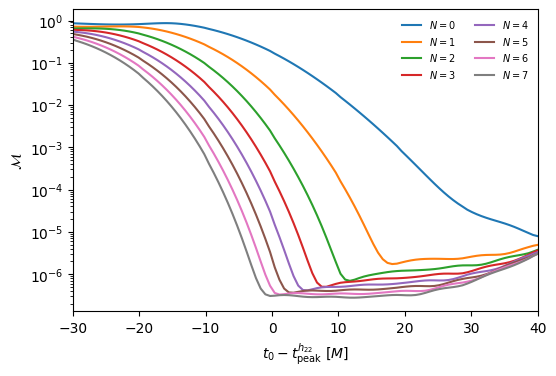

In [5]:
# We will fit to the (2,2) spherical harmonic mode, with the following
# combinations of modes:
hlm_modes = [(2,2)]
mode_list = [[(2,2,n) for n in range(N)] for N in range(1,7+2)]

# The start times to use
t0_array = np.linspace(-30, 40, 100)

# Create figure
fig, ax = plt.subplots(dpi=100)

for modes in mode_list:
    
    # Create mismatch list
    mm_list = sim.mismatch_t0_array(
        t0_array, 
        T_array=100, 
        modes=modes, 
        hlm_modes=hlm_modes)
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, label=f'$N = {modes[-1][-1]}$')
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)

## Vary remnant mass and spin in the fit

We can easily perform fits over a grid of remnant mass and spin values with the `sim.mismatch_M_chi_grid` method. This returns a grid of mismatch values.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:17<00:00, 144.10it/s]


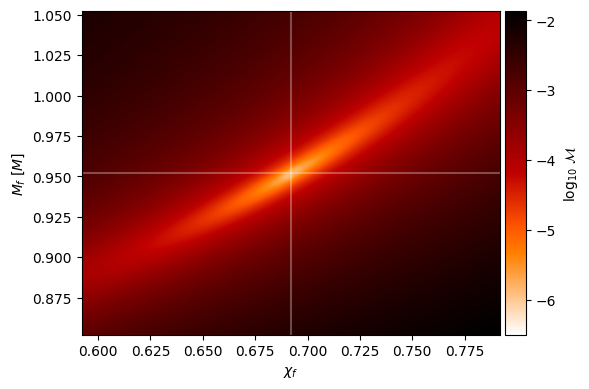

In [6]:
# Perform a fir from the time of peak strain with seven overtones:
hlm_modes = [(2,2)]
modes = [(2,2,n) for n in range(7+1)]

t0 = 0
T = 100

# We provide tuples for the mass and spin to define the grid boundaries
mm_grid = sim.mismatch_M_chi_grid(
    [sim.Mf-0.1, sim.Mf+0.1], 
    [sim.chif_mag-0.1, sim.chif_mag+0.1],
    res=50, 
    t0=t0, 
    T=T, 
    modes=modes, 
    hlm_modes=hlm_modes)

# There is a function to plot the result from the last mismatch_M_chi_grid call
sim.plot_mismatch_M_chi_grid(fig_kw={'dpi':100})

In [7]:
# Finally, we can calculate "epsilon" (that is, the "distance" between the true
# remnant mass and spin, and the mass and spin which minimize the mismatch)
# either using a pre-computed grid or by using a minimization method available
# in scipy.optimize.minimize
epsilon, delta_M, delta_chi = sim.calculate_epsilon(
    t0=t0, T=T, modes=modes, hlm_modes=hlm_modes, method='Nelder-Mead')

print(f'\n\nepsilon = {epsilon}')
print(f'delta_M = {delta_M}')
print(f'delta_chi = {delta_chi}\n')



epsilon = 0.0003376272364647207
delta_M = -0.00023355648512601856
delta_chi = 0.00024381399614337163

